<a href="https://colab.research.google.com/github/thetinybug/Django-Project/blob/master/IDS_WGAN_and_GenerateAdversarialTraffic_(Keras)Loss(-).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Một số biến toàn cục**

##**0.1 Paths**

In [1]:
# Modules Path
ModulePath = "/content/drive/My Drive/Study/KLTN/Google Colab/0.0 Python Modules/"


# Dataset Path
Dataset_Path = "/content/drive/My Drive/Study/KLTN/Dataset/NSL-KDD Processed/Final - For Using/"
Trainsets_Path = Dataset_Path + 'Trainset/'
# Trainset
g_trainset_path = Trainsets_Path + "GAN-G.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
# Testset
testset_path = Dataset_Path + "Testset/" + "KDDTest+.csv"

# Saved Models Path
SavedModelPath = "/content/drive/My Drive/Study/KLTN/Saved Model/"

# GAN
GAN_SavedModelPath = SavedModelPath + "GANModel/"

# Blackbox IDS
IDS_DOS_ModelPath = SavedModelPath + "IDSModel/DOS/" + "Keras_IDS_CNN.h5"
IDS_U2R_AND_R2L_ModelPath = SavedModelPath + "IDSModel/U2R_AND_R2L/" + "Keras_IDS_CNN.h5"

##**0.2 Variables**

In [2]:
# Choose Attack Category
ATTACK_CATEGORY = 'DOS'

#**1. Chuẩn bị**

##1.1 Thư viện

###1.1.1. Cài đặt các thư viện cần thiết

In [3]:
!pip3 install numpy adabound torc sklearn matplotlib pandas

In [4]:
# Lib for print table
!pip3 install prettytable

###1.1.2. Import thư viện

In [5]:
# Add Module Path - To Import Custom Modules
import sys
sys.path.append(ModulePath)

In [6]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Libs for Keras
from keras.models import load_model


# Own Custom Module to import models and constants
from models import *
from constants import *

import matplotlib.pyplot as plt
import adabound 
import math
from prettytable import PrettyTable

Using TensorFlow backend.


##1.2 Hàm

In [7]:
# BlackboxIDS = DefaultBlackboxIDS



###1.2.1 Tạo Batch

In [8]:
# Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)

    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]

    return batch_x

###1.2.2 Tiền xử lý dữ liệu

In [9]:
# Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset, attack_category):
    # 2 Category: DoS, U2R&R2L
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")

    if attack_category == 'DOS':
      # DOS 
      attack_data = dataset[dataset['class'] == 'DOS']
    else:
      # U2R_AND_R2L
      attack_data = dataset[dataset['class'] == 'U2R_AND_R2L']

    # Del label
    del attack_data["class"]

    return np.array(attack_data)

###1.2.3 Hàm tạo Noise
  - **DOS**: 
    - **Giữ lại**: Intrinsic, Time-based traffic.
    - **Thay đổi**: Content, Host-based traffic.
  - **U2R&R2L**:
    - **Giữ lại**: Intrinsic, Content.
    - **Thay đổi**: Time-based traffic, Host-based traffic.

In [10]:
# Make Noise
def MakeNoise(attack_category, n_feature, n_record):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")

    # Create noise array
    noise = np.random.uniform(-1,1,(n_feature,n_record))

    # retain feature
    # DOS : INTRINSIC, TIMEBASED
    if attack_category == 'DOS':
      noise[:, INTRINSIC_INDEX + TIMEBASED_INDEX] = 0
    else:
      # U2R&R2L: INTRINSIC, CONTENT
      noise[:, INTRINSIC_INDEX + CONTENT_INDEX] = 0
    
    return noise

##1.3 Chuẩn bị dataset

In [11]:
## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

# All attack record in train_data
raw_attack = preprocess_malicious_data(g_train_data, ATTACK_CATEGORY)
# All normal record in train_data
del d_train_data["class"]
normal = np.array(d_train_data)

# batch_size, epoch, critic_iters
NUMBER_OF_FEATURES = len(d_train_data.columns)
BATCH_SIZE = 64
MAX_EPOCH = 100


print("Amout of Generator Trainset:", g_train_data.shape[0])
print("Amout of Discriminator Trainset:", d_train_data.shape[0])

Amout of Generator Trainset: 23488
Amout of Discriminator Trainset: 33672


In [12]:
print(g_train_data.shape)

(23488, 42)


# **2. Định nghĩa Model**

##**2.1. Tạo Model**

###2.1.1. GAN

In [13]:
# GAN Model
# GAN - Generator
class Generator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim //2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim // 2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,output_dim),
            # 08/05 - Add Tanh func.
            nn.Tanh()
        )
    def forward(self, noise):
        output = self.layer(noise)
        # return restrict output in range[0,1]
        return th.clamp(output,0.,1.)

# GAN - Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim * 2, input_dim *2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2 , input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,input_dim//2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim//2,output_dim)
        )

    def forward(self,x):
        return self.layer(x)

# Retain feature
def Retain_Features(adversarial, raw, attack_category):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
        raise ValueError("Preprocess Data Fail: Invalid Attack Category")

    for idx, adversarial_val in enumerate(adversarial):
        if attack_category == 'DOS':
            adversarial_val[DOS_FEATURES] = raw[idx][DOS_FEATURES]
        else:
            adversarial_val[U2R_AND_R2L_FEATURES] = raw[idx][U2R_AND_R2L_FEATURES]
    
    return adversarial


# Instantiate Model Class
D_G_INPUT_DIM = NUMBER_OF_FEATURES        # Number of dimension from dataset
G_OUTPUT_DIM = NUMBER_OF_FEATURES         # Number of dimension from dataset
D_OUTPUT_DIM = 1                          # A value [0,1] mean it is Normal Traffic or Arnomaly Traffic
LAMBDA = 10                               # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5                          # For WGAN and WGAN-GP, number of critic iters per gen iter
CLAMP = 0.01

# Create GAN Models
generator = Generator(D_G_INPUT_DIM,G_OUTPUT_DIM)
discriminator = Discriminator(D_G_INPUT_DIM,D_OUTPUT_DIM)

# Adam Optimizer 
learning_rate = 0.0001
optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

###2.1.2 IDS

In [14]:
# Keras Model
ids_model = load_model(IDS_DOS_ModelPath)
ids_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 38, 128)           640       
_________________________________________________________________
flatten_3 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4864)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               622720    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 624,130
Trainable params: 623,874
Non-trainable params: 256
______________________________________________

##2.2. Hàm tính Penalty

In [15]:
# Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# **3. Run Model**

##**3.1 Run IDSGAN**

###**3.1.1 Run IDSGAN**

In [17]:
d_losses,g_losses = [],[]
# ids_model.eval()
generator.train()
discriminator.train()

IDS_MODEL = 'CNN'

# Create batch of attack traffic
batch_attack = create_batch2(raw_attack,BATCH_SIZE)

print("***IDSGAN start training")
print(f"#ATTACK CATEGORY: {ATTACK_CATEGORY}; IDS MODEL: {IDS_MODEL}")

table_result = PrettyTable(['Epoch', 'G-Loss', 'D-Loss'])
print(f"{5*' '}Epoch{15*' '}G-Loss{18*' '}D-Loss")

for epoch in range(10):
# for epoch in range(MAX_EPOCH):
    cnt = 0
    # print(f"Epoch    {epoch}---")
    # Comment - Mỗi train epoch tạo batch 1 lần
    batch_normal = create_batch2(normal,BATCH_SIZE)
    run_g_loss = 0.
    run_d_loss = 0.
    for idx, bn in enumerate(batch_normal):
        normal_b = th.Tensor(bn.astype("float64"))
        #  Train Generator
        for p in discriminator.parameters():  
            p.requires_grad = False
    
        optimizer_G.zero_grad()        
        
        # Create Adversarial Attack Traffic
        attack_traffic = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
        noise = MakeNoise(ATTACK_CATEGORY, len(attack_traffic), D_G_INPUT_DIM)
        z = V(th.Tensor(noise))

        adversarial_attack = generator(z)
        adversarial_attack = Retain_Features(adversarial_attack, attack_traffic, ATTACK_CATEGORY)


        D_pred = discriminator(adversarial_attack)
        # # 26/06 - g_loss = -th.mean(D_pred) -> Doi thanh nhu bai bao o duoi
        # g_loss = th.mean(D_pred)

        # Giu nguyen
        g_loss = -th.mean(D_pred)

        g_loss.backward()
        optimizer_G.step()
        
        run_g_loss += g_loss.item()
        # Train Discreminator
        for p in discriminator.parameters(): 
            p.requires_grad = True

        for c in range(CRITIC_ITERS):
            optimizer_D.zero_grad()
            for p in discriminator.parameters():
                p.data.clamp_(-CLAMP, CLAMP)
                
            ids_input = th.cat((adversarial_attack,normal_b))

            # Shuffle Input
            l = list(range(len(ids_input)))
            np.random.shuffle(l)
            ids_input = V(th.Tensor(ids_input[l]))
            # Change Format for Keras
            ids_input_keras = ids_input.reshape(ids_input.shape[0], NUMBER_OF_FEATURES, 1)
            ids_pred = ids_model.predict(ids_input_keras)
            # to torch.tensor
            ids_pred = V(th.Tensor(ids_pred))
            ids_pred_lable = th.argmax(nn.Sigmoid()(ids_pred),dim = 1).detach().numpy()

            pred_normal = ids_input.numpy()[ids_pred_lable==0]
            pred_attack = ids_input.numpy()[ids_pred_lable==1]
            

            if len(pred_attack) == 0:
                cnt += 1
                break
            D_noraml = discriminator(V(th.Tensor(pred_normal)))
            D_attack= discriminator(V(th.Tensor(pred_attack)))
            
            loss_normal = th.mean(D_noraml)
            loss_attack = th.mean(D_attack)
            # gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)
            
            # 26/06 - d_loss = loss_attack - loss_normal -> Doi thanh nhu bai bao o duoi
            # d_loss =  loss_normal - loss_attack #+ LAMBDA * gradient_penalty

            # Giu nguyen
            d_loss = loss_attack - loss_normal

            d_loss.backward()
            optimizer_D.step()
            run_d_loss += d_loss.item()
            
    d_losses.append(run_d_loss/CRITIC_ITERS)
    g_losses.append(run_g_loss)
    print(f"{5*' '}{epoch:5d}{15*' '}{run_g_loss:3.4f}{18*' '}{run_d_loss/CRITIC_ITERS:3.4f}")
    # print(f"G_Loss = {run_g_loss} \t D_Loss = {run_d_loss/CRITIC_ITERS}")
    
    table_result.add_row([epoch, run_g_loss, run_d_loss/CRITIC_ITERS])

    if cnt >= (len(normal)/BATCH_SIZE):
        print("Not exist predicted attack traffic")
        break
print("IDSGAN finish training")


***IDSGAN start training
#ATTACK CATEGORY: DOS; IDS MODEL: CNN
     Epoch               G-Loss                  D-Loss
         0               -7.4549                -1.2934
         1               -7.5656                -1.2665
         2               -6.9964                -1.2967
         3               -6.6135                -1.2765
         4               -6.0895                -1.3107
         5               -6.3380                -1.2722
         6               -5.9661                -1.2686
         7               -6.0266                -1.2777
         8               -6.1959                -1.2936
         9               -6.0031                -1.2985
IDSGAN finish training


***Thứ tự của D-Loss và G-Loss ở trên bị lộn. Ở bảng phía dưới là chính xác***

In [18]:
print(table_result)

+-------+---------------------+---------------------+
| Epoch |        G-Loss       |        D-Loss       |
+-------+---------------------+---------------------+
|   0   |  -7.45486675389111  | -1.2934133229777216 |
|   1   |  -7.565618351101875 | -1.2665405141189694 |
|   2   |  -6.996428198181093 | -1.2967274780385196 |
|   3   |  -6.613500509411097 | -1.2765142639167606 |
|   4   |  -6.089539566077292 | -1.3107234163209796 |
|   5   |  -6.337970092892647 | -1.2721560976468027 |
|   6   |  -5.966067174449563 | -1.2686306161805987 |
|   7   |  -6.026587700471282 | -1.2777475918643177 |
|   8   |  -6.195909616537392 |  -1.293563328217715 |
|   9   | -6.0030783880501986 | -1.2984525254927575 |
+-------+---------------------+---------------------+


###**3.1.2 Show Graph**

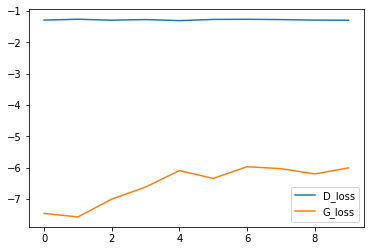

In [19]:
# Show Graph
plt.plot(d_losses,label = "D_loss")
plt.plot(g_losses, label = "G_loss")
plt.legend()
plt.show()

###**3.1.3 Save Model**

In [20]:
GAN_G_Model_Path = GAN_SavedModelPath + "Generator/" + IDS_MODEL+ "_" + ATTACK_CATEGORY + "_" + str(MAX_EPOCH) + "epoch.pth"
GAN_D_Model_Path = GAN_SavedModelPath + "Discriminator/" + IDS_MODEL+ "_" + ATTACK_CATEGORY + "_" + str(MAX_EPOCH) + "epoch.pth"

In [21]:
# Save Model
th.save(generator.state_dict(), GAN_G_Model_Path)
th.save(discriminator.state_dict(), GAN_D_Model_Path)

##**3.2 Run Generate Adversarial Traffic**

###**3.2.0 Hàm tạo Batch**

In [22]:
# Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return batch_x

###**3.2.1 Load Testset**
- test_raw_attack: Tất cả Malicious record của 1 loại tấn công(ATTACK_CATEGORY) trong KDDTest+.
- test_normal: Tất cả Normal record trong KDDTest+.

**Label**
- test_raw_attack: 1
- test_normal: 0

In [23]:
# Load Testset
testset = pd.read_csv(testset_path)

# test_raw_attack
test_raw_attack = preprocess_malicious_data(testset, ATTACK_CATEGORY)
# test_normal
test_normal = np.array(testset[testset["class"] == 'Normal'])[:,:-1]

print(f"Amount of {ATTACK_CATEGORY} in testset:\t{len(test_raw_attack)}")
print(f"Amount of Normal in testset:\t{len(test_normal)}")

Amount of DOS in testset:	7460
Amount of Normal in testset:	9711


###**3.2.2 Read Model**

In [24]:
# Declare Batch size and Dimensions
BATCH_SIZE = 256 # Batch size
D_G_INPUT_DIM = test_normal.shape[1]
G_OUTPUT_DIM =test_normal.shape[1] 
D_OUTPUT_DIM = 1

# Read model
# Read GAN-G
random_g = Generator(D_G_INPUT_DIM,G_OUTPUT_DIM)
leaned_g = Generator(D_G_INPUT_DIM,G_OUTPUT_DIM)
# Load Param for GAN-G Learned
g_param = th.load(GAN_G_Model_Path,map_location=lambda x,y:x)
leaned_g.load_state_dict(g_param)

# Keras Model
ids_model = load_model(IDS_DOS_ModelPath)
ids_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 38, 128)           640       
_________________________________________________________________
flatten_3 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4864)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               622720    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 624,130
Trainable params: 623,874
Non-trainable params: 256
______________________________________________

###**3.2.3 Generate Traffic**

In [25]:
model_g = {"No Train Model":random_g,"Trained Model":leaned_g}

# Create batch of attack traffic
batch_attack = create_batch2(test_raw_attack,BATCH_SIZE)
n_batch_attack = len(batch_attack)

test_batch_normal = create_batch2(test_normal,BATCH_SIZE)

print(f"Num. Attack Batchs: {n_batch_attack}")
print(f"Num. Normal Batchs: {len(test_batch_normal)}")

print("Adversarial Traffic Evaluating")
print("-"*100)
for model_name,g in model_g.items():
    o_dr,a_dr,eir=[],[],[]
    g.eval()
    with th.no_grad():
        for idx, bn in enumerate(test_batch_normal):
            normal_b = th.Tensor(bn.astype("float64"))

            # Gen Adversarial Traffic
            attack_traffic = V(th.Tensor(batch_attack[idx % n_batch_attack]))
            noise = MakeNoise(ATTACK_CATEGORY, len(attack_traffic), D_G_INPUT_DIM)
            z = V(th.Tensor(noise))

            adversarial_attack = generator(z)
            adversarial_attack = Retain_Features(adversarial_attack, attack_traffic, ATTACK_CATEGORY)
                        
            batch_a = th.Tensor(attack_traffic)

            # IDS Input
            ori_input = th.cat((batch_a,normal_b))
            adv_input = th.cat((adversarial_attack,normal_b))
            l = list(range(len(ori_input)))
            np.random.shuffle(l)
            adv_input = adv_input[l]
            ori_input = ori_input[l]

            adv_input = adv_input.reshape(adv_input.shape[0], NUMBER_OF_FEATURES, 1)
            ori_input = ori_input.reshape(ori_input.shape[0], NUMBER_OF_FEATURES, 1)

            ids_pred_adv = ids_model.predict(adv_input)
            ids_pred_ori = ids_model.predict(ori_input)
            # To Torch
            ids_pred_adv = V(th.Tensor(ids_pred_adv))
            ids_pred_ori = V(th.Tensor(ids_pred_ori))
            # IDS input co dang: attack (BATCH_SIZE phan tu) --> normal (BATCH_SIZE phan tu)
            ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
            pred_label_adv = th.argmax(nn.Sigmoid()(ids_pred_adv),dim = 1).cpu().numpy()
            pred_label_ori = th.argmax(nn.Sigmoid()(ids_pred_ori),dim = 1).cpu().numpy()
            
            
            tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,pred_label_adv).ravel()
            tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,pred_label_ori).ravel()

            # print(f"tn1, fn1, fp1, tp1 = {tn1, fn1, fp1, tp1}")
            # print(f"tn2, fn2, fp2, tp2 = {tn2, fn2, fp2, tp2}")

            o_dr.append(tp2/(tp2 + fp2))
            a_dr.append(tp1/(tp1 + fp1))
            eir.append(1 - (tp1/(tp1 + fp1))/(tp2/(tp2 + fp2)))
    print(f"{model_name}\t =>\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {np.mean(eir)*100:.2f}%")   


Num. Attack Batchs: 29
Num. Normal Batchs: 37
Adversarial Traffic Evaluating
----------------------------------------------------------------------------------------------------
No Train Model	 =>	Origin DR : 80.01% 	 Adversarial DR : 0.91% 	 EIR : 98.86%
Trained Model	 =>	Origin DR : 80.01% 	 Adversarial DR : 0.82% 	 EIR : 98.97%


The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)